In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [155]:
!pip install torchsummary
!pip install onnx
!pip install onnxscript
!pip install onnxruntime

In [156]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [157]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms, models, datasets
from glob import glob
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
from torchsummary import summary
import torchmetrics
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import onnx
import onnxruntime
#from google.colab.patches import cv2_imshow

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [158]:
class CustomDataset(Dataset):

    def __init__(self, folder, data, transform = None):

        self.transform = transform
        self.folder = folder
        self.data = data
        self.fpaths = [i for i in sorted(glob(f"{self.folder}/{self.data}/*.jpg"))]
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].split('_')[0] for fpath in self.fpaths]
        self.targets = ['0' if len(i) != 1 else i for i in self.targets]

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, idx):

        f = self.fpaths[idx]
        target = int(self.targets[idx])
        im = Image.open(f)
        im = self.transform(im)
        return im, target

class Identity():
    def __call__(self, im):
        return im

def make_transform(is_train = True):
    resnet_mean = [0.485, 0.456, 0.406]
    resnet_std = [0.229, 0.224, 0.225]
    resnet_transform = transforms.Compose([
        transforms.RandomHorizontalFlip() if is_train else Identity(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=resnet_mean, std=resnet_std)
    ])
    return resnet_transform

In [159]:
def get_dls(train_data, test_data, batch_size, ns = 4):
    train_dl = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = ns)
    val_dl = DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = ns)

    return train_dl, val_dl

In [ ]:
folder = "/content" #Folder to Dataset
batch_size = 32
train_data = CustomDataset(folder = folder, data = "train", transform = make_transform(is_train=True))
test_data = CustomDataset(folder = folder, data = "test", transform = make_transform(is_train=False))
train_dl, val_dl = get_dls(train_data, test_data, batch_size = 32)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1


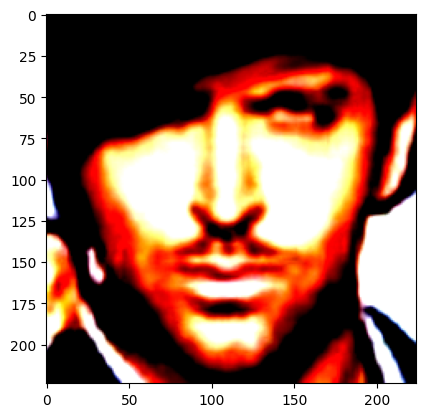

In [161]:
im, gt = train_dl.dataset[0]
plt.imshow(im.permute(1,2,0).cpu())
print(gt)

In [162]:
target = train_data.targets
sum = len(train_data.targets)
classes = set(target)
weights = []
for i in classes:
  weights.append(sum/target.count(i))
print(weights)

[5.790137614678899, 4.005553351844506, 3.1331058020477816, 3.8689655172413793]


In [163]:
# @title Resnet18
class Model(nn.Module):
     def __init__(self, num_classes):
         super().__init__()
         self.network = models.resnet18(pretrained=True)
         number_of_features = self.network.fc.in_features
         self.network.fc = nn.Linear(number_of_features, num_classes)

     def forward(self, xb):
         return self.network(xb)

     def freeze(self):
         for param in self.network.parameters():
             param.requires_grad= False
         for param in self.network.fc.parameters():
             param.requires_grad= True

     def unfreeze(self):
         for param in self.network.parameters():
            param.requires_grad= True

model=Model(4).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [164]:
epochs = 100
lr = 1e-4
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights)).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)

In [165]:
# @title Wandb
wandb.init(    # set the wandb project where this run will be logged
    project="Beeline ТЗ",
    # track hyperparameters and run metadata
    config={
        "dataset": "Beeline",
        "classes": len(classes),
        "architecture": "Resnet18",
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        'criterion': 'CrossEntropyLoss',
        'optimizer': 'AdamW',
        "image_size": 224,
        "train": len(train_dl),
        'valid': len(val_dl),
        "params": '2,857,476',
        "size_MB": '450.94',
    })

train_acc,▁▃▄▅▆▆▇▇▇▇█▇█████████████
train_f1,▁▃▄▅▆▆▇▇▇▇█▇█████████████
train_loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▅▆▃▅▄▇▆▇▇▅▆▆█▅█▇▆▆▅▅▇▇
val_f1,▂▃▃▄▅▂▂▃▇▆▅▇▄▆▇█▁█▆▇▂▄▃▇▇
val_loss,▃▂▃▂▃▃▅▂▁▂▂▁▄▃▂▁█▁▆▃▆▄▆▂▂
train_acc,0.99346
train_f1,0.99347
train_loss,0.02022
val_acc,0.89216
val_f1,0.91406


In [166]:
# @title Train
def move_to_device(data_batch, device):
    return data_batch[0].to(device), data_batch[1].to(device)

def compute_metrics(model, inputs, labels, loss_func, total_loss, total_accuracy, total_f1):
    predictions = model.forward(inputs)
    loss = loss_func(predictions, labels)
    return (
        loss,
        total_loss + loss.item(),
        total_accuracy + (torch.argmax(predictions, dim=1) == labels).sum().item(),
        total_f1 + f1_metric(predictions, labels)
    )

f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(device)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

highest_accuracy, lowest_loss = 0, float("inf")
no_improve_counter, early_stopping_patience = 0, 10
train_losses, validation_losses, train_accuracies, validation_accuracies, train_f1_scores, validation_f1_scores = [], [], [], [], [], []

for epoch in range(epochs):
    print(f'--------------------- Epoch: {epoch} ----------------------')
    model.train()
    epoch_train_loss, epoch_train_accuracy, epoch_train_f1 = 0, 0, 0
    for idx, data_batch in tqdm(enumerate(train_dl), total=len(train_dl)):
        inputs, labels = move_to_device(data_batch, device)

        loss, epoch_train_loss, epoch_train_accuracy, epoch_train_f1 = compute_metrics(model, inputs, labels, loss_fn, epoch_train_loss, epoch_train_accuracy, epoch_train_f1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = epoch_train_loss / len(train_dl)
    avg_train_accuracy = epoch_train_accuracy / len(train_dl.dataset)
    avg_train_f1 = epoch_train_f1 / len(train_dl)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    train_f1_scores.append(avg_train_f1)

    lr_scheduler.step(train_losses[-1])

    print(f"train_loss  - {avg_train_loss:.3f}")
    print(f"train_acc   - {avg_train_accuracy:.3f}")
    print(f"epoch train_f1    - {avg_train_f1:.3f}")

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_accuracy, val_epoch_f1 = 0, 0, 0
        for idx, data_batch in enumerate(val_dl):
            inputs, labels = move_to_device(data_batch, device)
            loss, val_epoch_loss, val_epoch_accuracy, val_epoch_f1 = compute_metrics(model, inputs, labels, loss_fn, val_epoch_loss, val_epoch_accuracy, val_epoch_f1)

        avg_val_loss = val_epoch_loss / len(val_dl)
        avg_val_accuracy = val_epoch_accuracy / len(val_dl.dataset)
        avg_val_f1 = val_epoch_f1 / len(val_dl)
        validation_losses.append(avg_val_loss)
        validation_accuracies.append(avg_val_accuracy)
        validation_f1_scores.append(avg_val_f1)

        print(f"val_loss  - {avg_val_loss:.3f}")
        print(f"val_acc   - {avg_val_accuracy:.3f}")
        print(f"val_f1    - {avg_val_f1:.3f}")

        if avg_val_loss < lowest_loss:
            lowest_loss = avg_val_loss
            torch.save(model.state_dict(), f"{epoch}_best_model.pth")
            no_improve_counter = 0
        else:
            no_improve_counter += 1
            print(f"Loss value did not decrease for {no_improve_counter} epochs")
            if no_improve_counter >= early_stopping_patience:
                print(f"Stopping training since loss did not decrease for {early_stopping_patience} epochs.")
                break

    wandb.log({"train_acc": avg_train_accuracy, "train_loss": avg_train_loss, 'train_f1': avg_train_f1, "val_acc": avg_val_accuracy, "val_loss": avg_val_loss, 'val_f1': avg_val_f1})
    print(f'------------------------------------------------------')

--------------------- Epoch: 0 ----------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 316/316 [00:48<00:00,  6.57it/s]

train_loss  - 0.740
train_acc   - 0.654
epoch train_f1    - 0.653


val_loss  - 0.650
val_acc   - 0.716
val_f1    - 0.638
------------------------------------------------------
--------------------- Epoch: 1 ----------------------


100%|██████████| 316/316 [00:39<00:00,  8.03it/s]

train_loss  - 0.531
train_acc   - 0.752
epoch train_f1    - 0.752


val_loss  - 0.477
val_acc   - 0.775
val_f1    - 0.786
------------------------------------------------------
--------------------- Epoch: 2 ----------------------


100%|██████████| 316/316 [00:41<00:00,  7.67it/s]

train_loss  - 0.424
train_acc   - 0.807
epoch train_f1    - 0.807


val_loss  - 0.423
val_acc   - 0.824
val_f1    - 0.826
------------------------------------------------------
--------------------- Epoch: 3 ----------------------


100%|██████████| 316/316 [00:40<00:00,  7.89it/s]


train_loss  - 0.326
train_acc   - 0.854
epoch train_f1    - 0.854
val_loss  - 0.373
val_acc   - 0.863
val_f1    - 0.891
------------------------------------------------------
--------------------- Epoch: 4 ----------------------


100%|██████████| 316/316 [00:39<00:00,  7.94it/s]

train_loss  - 0.257
train_acc   - 0.889
epoch train_f1    - 0.889


val_loss  - 0.545
val_acc   - 0.775
val_f1    - 0.753
Loss value did not decrease for 1 epochs
------------------------------------------------------
--------------------- Epoch: 5 ----------------------


100%|██████████| 316/316 [00:39<00:00,  8.01it/s]

train_loss  - 0.212
train_acc   - 0.911
epoch train_f1    - 0.911


val_loss  - 0.345
val_acc   - 0.833
val_f1    - 0.867
------------------------------------------------------
--------------------- Epoch: 6 ----------------------


100%|██████████| 316/316 [00:39<00:00,  8.07it/s]

train_loss  - 0.165
train_acc   - 0.934
epoch train_f1    - 0.934


val_loss  - 0.411
val_acc   - 0.853
val_f1    - 0.849
Loss value did not decrease for 1 epochs
------------------------------------------------------
--------------------- Epoch: 7 ----------------------


100%|██████████| 316/316 [00:38<00:00,  8.27it/s]


train_loss  - 0.121
train_acc   - 0.949
epoch train_f1    - 0.949
val_loss  - 0.269
val_acc   - 0.833
val_f1    - 0.867
------------------------------------------------------
--------------------- Epoch: 8 ----------------------


100%|██████████| 316/316 [00:38<00:00,  8.31it/s]


train_loss  - 0.122
train_acc   - 0.950
epoch train_f1    - 0.950
val_loss  - 0.304
val_acc   - 0.863
val_f1    - 0.891
Loss value did not decrease for 1 epochs
------------------------------------------------------
--------------------- Epoch: 9 ----------------------


100%|██████████| 316/316 [00:38<00:00,  8.28it/s]

train_loss  - 0.095
train_acc   - 0.963
epoch train_f1    - 0.963


val_loss  - 0.475
val_acc   - 0.843
val_f1    - 0.807
Loss value did not decrease for 2 epochs
------------------------------------------------------
--------------------- Epoch: 10 ----------------------


100%|██████████| 316/316 [00:38<00:00,  8.30it/s]

train_loss  - 0.095
train_acc   - 0.964
epoch train_f1    - 0.964


val_loss  - 0.511
val_acc   - 0.853
val_f1    - 0.849
Loss value did not decrease for 3 epochs
------------------------------------------------------
--------------------- Epoch: 11 ----------------------


100%|██████████| 316/316 [00:38<00:00,  8.27it/s]

train_loss  - 0.071
train_acc   - 0.975
epoch train_f1    - 0.975


val_loss  - 0.476
val_acc   - 0.843
val_f1    - 0.875
Loss value did not decrease for 4 epochs
------------------------------------------------------
--------------------- Epoch: 12 ----------------------


100%|██████████| 316/316 [00:38<00:00,  8.27it/s]

train_loss  - 0.072
train_acc   - 0.972
epoch train_f1    - 0.972


val_loss  - 0.459
val_acc   - 0.843
val_f1    - 0.875
Loss value did not decrease for 5 epochs
------------------------------------------------------
--------------------- Epoch: 13 ----------------------


100%|██████████| 316/316 [00:38<00:00,  8.25it/s]

train_loss  - 0.065
train_acc   - 0.977
epoch train_f1    - 0.977


val_loss  - 0.520
val_acc   - 0.853
val_f1    - 0.883
Loss value did not decrease for 6 epochs
------------------------------------------------------
--------------------- Epoch: 14 ----------------------


100%|██████████| 316/316 [00:38<00:00,  8.18it/s]

train_loss  - 0.058
train_acc   - 0.978
epoch train_f1    - 0.978


val_loss  - 0.466
val_acc   - 0.843
val_f1    - 0.875
Loss value did not decrease for 7 epochs
------------------------------------------------------
--------------------- Epoch: 15 ----------------------


100%|██████████| 316/316 [00:38<00:00,  8.17it/s]

train_loss  - 0.057
train_acc   - 0.979
epoch train_f1    - 0.979


val_loss  - 0.754
val_acc   - 0.824
val_f1    - 0.724
Loss value did not decrease for 8 epochs
------------------------------------------------------
--------------------- Epoch: 16 ----------------------


100%|██████████| 316/316 [00:38<00:00,  8.16it/s]

train_loss  - 0.061
train_acc   - 0.976
epoch train_f1    - 0.976


val_loss  - 0.618
val_acc   - 0.824
val_f1    - 0.859
Loss value did not decrease for 9 epochs
------------------------------------------------------
--------------------- Epoch: 17 ----------------------


100%|██████████| 316/316 [00:38<00:00,  8.17it/s]

train_loss  - 0.059
train_acc   - 0.977
epoch train_f1    - 0.977


val_loss  - 0.364
val_acc   - 0.873
val_f1    - 0.865
Loss value did not decrease for 10 epochs
Stopping training since loss did not decrease for 10 epochs.


In [167]:
torch.save(model.state_dict(), f"model.pth")

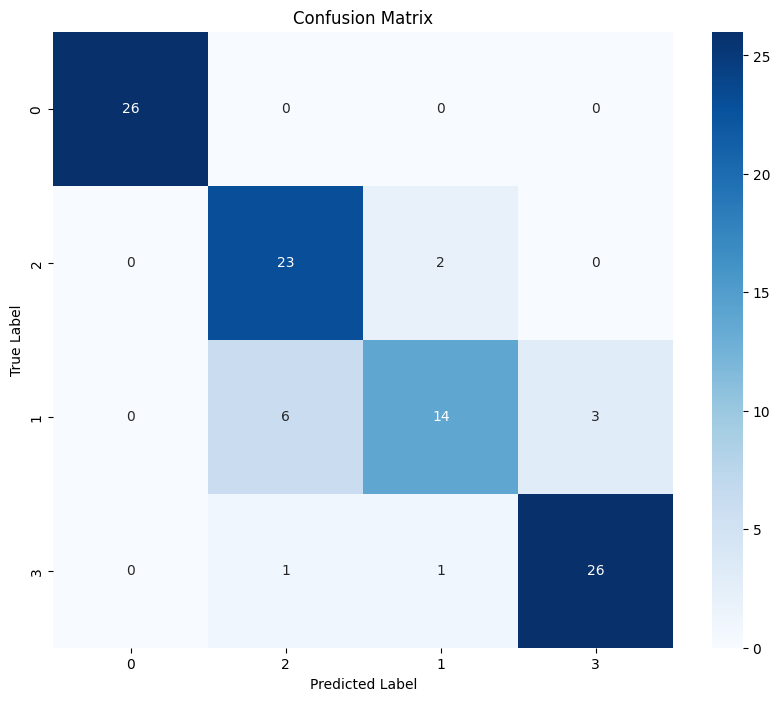

In [168]:
# @title Confusion Matrix on Test Data
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_dl:
        images, labels = batch[0].to(device), batch[1].to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [169]:
# @title Inference Pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model(4)
model.load_state_dict(torch.load("model.pth"))
model.to(device)
model.eval()

transform = make_transform(is_train=False)

def predict(img_path):
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    return predicted_class, probabilities[0][predicted_class].item()

def inference(input_path):
    if os.path.isdir(input_path):
        for filename in os.listdir(input_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(input_path, filename)
                pred_class, confidence = predict(img_path)
                print(f"{img_path} {pred_class} {confidence:.3f}")

    elif os.path.isfile(input_path):
        pred_class, confidence = predict(input_path)
        print(f"{input_path} {pred_class} {confidence:.3f}")
    else:
        print("Invalid input path")

print('---- Testing Folder ----')
input = "/content/test"
inference(input)
print('---- Testing Image ----')
input = "/content/test/0_0.jpg"
inference(input)
print('---- Testing Non existing images ----')
input = "/content/test/0.jpg"
inference(input)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-169-2da057386a69>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

---- Testing Folder ----
/content/test/3_82.jpg 3 1.000
/content/test/2_64.jpg 2 0.999
/content/test/3_84.jpg 3 0.995
/content/test/0_11.jpg 0 1.000
/content/test/0_1.jpg 0 0.996
/content/test/1_48.jpg 1 0.731
/content/test/3_63.jpg 3 0.926
/content/test/0_19.jpg 0 1.000
/content/test/1_36.jpg 1 0.999
/content/test/2_51.jpg 2 0.963
/content/test/1_39.jpg 1 0.998
/content/test/1_38.jpg 1 0.970
/content/test/0_9.jpg 0 0.990
/content/test/2_61.jpg 2 0.982
/content/test/3_86.jpg 3 1.000
/content/test/3_89.jpg 1 0.776
/content/test/0_6.jpg 0 1.000
/content/test/1_29.jpg 1 1.000
/content/test/1_26.jpg 1 0.999
/content/test/3_90.jpg 2 0.815
/content/test/2_57.jpg 1 0.998
/content/test/0_23.jpg 0 1.000
/content/test/1_49.jpg 1 0.999
/content/test/1_45.jpg 1 0.816
/content/test/3_75.jpg 3 1.000
/content/test/3_91.jpg 3 1.000
/content/test/0_12.jpg 0 0.999
/content/test/0_22.jpg 0 1.000
/content/test/0_20.jpg 0 1.000
/content/test/2_68.jpg 3 0.930
/content/test/0_17.jpg 0 0.975
/content/test/0_7

In [170]:
# @title Convert Pytorch model to ONNX
model=Model(4).to(device)
model.load_state_dict(torch.load("model.pth"))
model.eval()
torch_input = torch.randn(1, 3, 224, 224).to(device)

onnx_program = torch.onnx.dynamo_export(model, torch_input)
onnx_program.save("model_onnx.onnx")

<ipython-input-170-25d4f4c1db5d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))
/usr/local/lib/python3.10/dist-packages/torc

In [171]:
# @title Load ONNX model
onnx_model = onnx.load("model_onnx.onnx")
onnx.checker.check_model(onnx_model)

In [172]:
# @title Inference ONNX
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_session = onnxruntime.InferenceSession("model_onnx.onnx", providers=['CPUExecutionProvider'])

def onnx_predict(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)

    onnx_input = {ort_session.get_inputs()[0].name: to_numpy(input_tensor)}

    onnx_outputs = ort_session.run(None, onnx_input)

    prediction = np.argmax(onnx_outputs[0])
    confidence = np.max(onnx_outputs[0])

    return prediction, confidence

def inference(input_path):
    if os.path.isdir(input_path):
        for filename in os.listdir(input_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(input_path, filename)
                pred_class, confidence = predict(img_path)
                print(f"{img_path} {pred_class} {confidence:.3f}")

    elif os.path.isfile(input_path):
        pred_class, confidence = predict(input_path)
        print(f"{input_path} {pred_class} {confidence:.3f}")
    else:
        print("Invalid input path")


print('---- Testing Folder ----')
input = "/content/test"
inference(input)
print('---- Testing Image ----')
input = "/content/test/0_0.jpg"
inference(input)
print('---- Testing Non existing images ----')
input = "/content/test/0.jpg"
inference(input)

---- Testing Folder ----
/content/test/3_82.jpg 3 1.000
/content/test/2_64.jpg 2 0.999
/content/test/3_84.jpg 3 0.995
/content/test/0_11.jpg 0 1.000
/content/test/0_1.jpg 0 0.996
/content/test/1_48.jpg 1 0.731
/content/test/3_63.jpg 3 0.926
/content/test/0_19.jpg 0 1.000
/content/test/1_36.jpg 1 0.999
/content/test/2_51.jpg 2 0.963
/content/test/1_39.jpg 1 0.998
/content/test/1_38.jpg 1 0.970
/content/test/0_9.jpg 0 0.990
/content/test/2_61.jpg 2 0.982
/content/test/3_86.jpg 3 1.000
/content/test/3_89.jpg 1 0.776
/content/test/0_6.jpg 0 1.000
/content/test/1_29.jpg 1 1.000
/content/test/1_26.jpg 1 0.999
/content/test/3_90.jpg 2 0.815
/content/test/2_57.jpg 1 0.998
/content/test/0_23.jpg 0 1.000
/content/test/1_49.jpg 1 0.999
/content/test/1_45.jpg 1 0.816
/content/test/3_75.jpg 3 1.000
/content/test/3_91.jpg 3 1.000
/content/test/0_12.jpg 0 0.999
/content/test/0_22.jpg 0 1.000
/content/test/0_20.jpg 0 1.000
/content/test/2_68.jpg 3 0.930
/content/test/0_17.jpg 0 0.975
/content/test/0_7